## <center> Hybrid approaches in RecSys </center>


* Hybrid approaches classification
* Case study: next basket recommendations (X5 retail hero)

### Гибридные системы

На соревновании Netflix Prize 2006 - 2009 годов команда Bellkor Pragmatix Chaos выиграла приз в 1 миллион долларов за решение, в котором комбинировалось 107 различных алгоритмов; их программа повысила точность рекомендательного движка Cinematch на Netflix на 10.06%. С Netflix Prize началось активное развитие гибридных рекомендательных систем, так и всей RecSys области в целом.

Сегодня поговорим про гибридные подходы.

Одна из классификаций:

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week3/images/taxonomy.png'>


### Пример

К какому типу из классификации гибридных алгоритмов он относится?

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week3/images/twolevel.png'>

## Рекомендации следующей покупки с использованием каскадного (двухуровневого) подхода

Рассмотрим задачу построения рекомендательной системы для задачи рекомендации следующей покупки с хакатона [X5 retail hero](https://ods.ai/competitions/x5-retailhero-recommender-system/data).

Это типичная задача next-basket recommendation task.

По условиям соревнования, каждому пользователю должны выдать топ-20 рекомендованных товаров и посчитать метрику качества MNAP@20.

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week3/images/mnap.png' width=350 height=120>

где $r_u(i)$ — бинарная оценка за тестовый период купил ли клиент товар или нет,

$n_u$ — количество фактически купленных товаров пользователем за тестовый период,

$U$ — множество пользователей.

Попробуем применить простенький вариант двухуровневой архитектуры.
Суть моделей первого уровня - отобрать наиболее хорошие top-N кандидатов из товаров в рекомендации, чтобы сузить множество точно нерелевантных товаров.
Второй уровень, на котором возьмем градиентный бустинг, попробуем добавить признаки из моделей первого уровня (ранги и оценки релевантности).

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=806107 sha256=1a38a7409f39f7587d53c4278d09df1bf966cc6d80eca0e821ed121f74686dbf
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 17.4 MB/s eta 0:00:00


In [ ]:
import os

DATA_PATH = "./"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import warnings

warnings.filterwarnings("ignore")

import itertools
import pickle
import random
from datetime import datetime
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
import seaborn as sns
from lightfm import LightFM
from scipy.sparse import coo_matrix, csr_matrix, save_npz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [ ]:
# Прочитаем файлы с данными и изучим их
# маленькая выборка из датасета X5
try:
    receipts = pd.read_csv('purchase_small.csv')

except FileNotFoundError:
    from google.colab import drive
    drive.mount('/content/drive')
    receipts = pd.read_csv('/content/drive/My Drive/purchase_small.csv')

Mounted at /content/drive


In [ ]:

receipts.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,20eaa3aef8,1.0,68.0,NaN
1,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,dd18825b63,1.0,70.0,NaN
2,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,c63172f1dc,2.0,36.0,NaN
3,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,44384a83e2,1.0,23.0,NaN
4,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,4f9c1df858,1.0,79.0,NaN


#### Preprocessing

- Выделим отдельно дату транзакции, чтобы потом сделать split по дате
- Отфильтруем недостаточно активных пользователей и редко покупаемые товаров

In [ ]:
receipts['ymd'] = receipts['transaction_datetime'].apply(lambda x: x[:11])
ditrib = receipts['product_id'].value_counts()[:100].rename_axis('product_id').reset_index(name='counts')
fig = px.bar(ditrib, x="product_id", y="counts", color="counts")
fig.show()

In [ ]:
def filter_by_counts(df: pd.DataFrame, min_product_cnt=10, min_products_per_user=0) -> pd.DataFrame:
    '''
    min_product_cnt - minimum frequency of product_id's purchases among all receipts.
    min_product_ids_per_user - minimum unique product_ids per user.
    '''
    product_id_counts = df.product_id.value_counts()
    product_id_freq = set(product_id_counts[product_id_counts >= int(min_product_cnt)].index)
    df = df[df.product_id.isin(product_id_freq)]
    active_users = dict(receipts.groupby('client_id')['product_id'].nunique() > min_products_per_user)
    idxs = {k for k, v in active_users.items() if v == True}
    df = df[df.client_id.isin(idxs)]
    return df

In [ ]:
receipts = filter_by_counts(receipts, min_product_cnt=10, min_products_per_user=0)

#### Train-test split & cross-validation

1) Как делить данные на train и test?


<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week3/images/spliting.png' width=500 height=300>


- Сплит по пользователям
- Сплит по времени (обычный без нарушения хронологии, кросс-валидация с кумулятивным сплитом, скользящее временное окно)
- Сплит с маскировкой n% интеракций и в train, и в test.
- Сплит по минимальному числу айтемов в test (train).
- Для Next-item - у каждого пользователя откладываем в сторону в test только последний айтем.




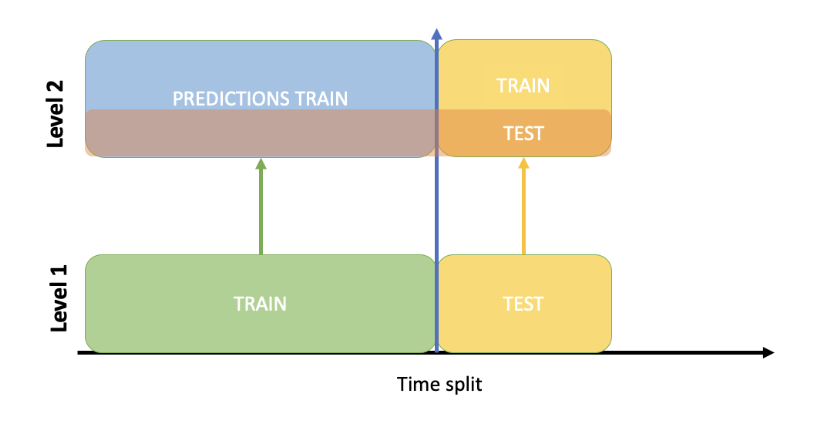

Как можно делать кросс-валидацию?
- Random k-fold
- Time-series
etc.



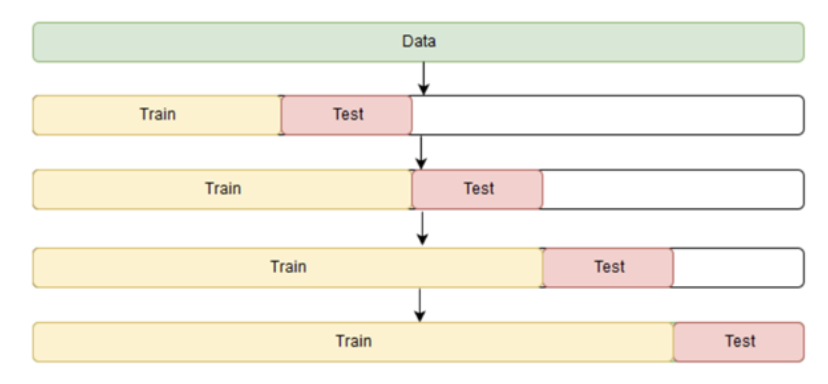

In [ ]:
def split_by_time(df: pd.DataFrame, split_date="2019-02-18", filter_train=10, filter_test=5):
    '''
    Function splits a data set into train and test by time.

    split_date - date for split 75% train and 25% test.
    filter_train - threshold for minimum number of unique product_ids purchased in train period.
    filter_test - threshold for minimum number of unique product_ids purchased in test period.
    '''
    df.ymd = df.ymd.apply(lambda x: x[:10])
    receipts_train = df[df.ymd < split_date]
    receipts_test = df[df.ymd >= split_date]

    user_train_cnt = receipts_train[["client_id", "product_id"]].drop_duplicates().client_id.value_counts()
    train_users = list(user_train_cnt[user_train_cnt >= filter_train].index)
    user_test_cnt = receipts_test[["client_id", "product_id"]].drop_duplicates().client_id.value_counts()
    test_users = list(user_test_cnt[user_test_cnt >= filter_test].index)

    users_final = set(train_users).intersection(set(test_users))

    receipts_train = receipts_train[receipts_train.client_id.isin(users_final)]
    receipts_test = receipts_test[receipts_test.client_id.isin(users_final)]

    assert receipts_train.client_id.nunique() == receipts_test.client_id.nunique()

    return receipts_train, receipts_test, list(users_final)

In [ ]:
# 75% train 25% test (по времени)
split_date_index = round(3 * receipts.ymd.nunique() / 4)
split_date = sorted(receipts.ymd.unique())[split_date_index]

receipts_train, receipts_test, users_final = split_by_time(receipts,
                                                           split_date=split_date,
                                                           filter_train=10,
                                                           filter_test=10)

In [ ]:
receipts_train.shape, receipts_test.shape

((14385, 14), (6135, 14))

Перевод в sparse матрицы, поскольку матрицы сильно разреженные.

In [ ]:
user_encoder, item_encoder = LabelEncoder(), LabelEncoder()
user_encoder.fit(users_final)

all_items = set(receipts_test.product_id.unique()).union(set(receipts_train.product_id.unique()))
item_encoder.fit(list(all_items))

receipts_train['client_new_id'] = user_encoder.transform(receipts_train['client_id'])
receipts_test['client_new_id'] = user_encoder.transform(receipts_test['client_id'])

receipts_train['product_new_id'] = item_encoder.transform(receipts_train['product_id'])
receipts_test['product_new_id'] = item_encoder.transform(receipts_test['product_id'])

matrix_shape = len(user_encoder.classes_), len(item_encoder.classes_)

train_sparse = coo_matrix((list(receipts_train.product_quantity.astype(np.float32)),
                           (list(receipts_train.client_new_id.astype(np.int64)),
                            list(receipts_train.product_new_id.astype(np.int64)))), shape=matrix_shape)


test_sparse = coo_matrix((list(receipts_test.product_quantity.astype(np.float32)),
                          (list(receipts_test.client_new_id.astype(np.int64)),
                           list(receipts_test.product_new_id.astype(np.int64)))), shape=matrix_shape)

In [ ]:
train_sparse.shape, test_sparse.shape

((205, 1007), (205, 1007))

Оценим LightFM

In [ ]:
# MNAP@20 for evaluating LightFM

def metric_lightfm(model, test_sparse, user_features, indices, total, k=20):

    ranks = model.predict_rank(test_sparse,
                               num_threads=60,
                               check_intersections=True,
                               user_features=user_features)
    mask = ranks.copy()
    mask.data = np.less(mask.data, k, mask.data)
    ranks.data += 1
    ranks.data = ranks.data * mask.data
    ranks.eliminate_zeros()
    ranks = ranks.tolil().data
    average_precision_sum = 0.0
    for x in indices:
        n_correct_items = 0
        precision = 0
        for y in sorted(ranks[x]):
            n_correct_items += 1
            precision += n_correct_items / y
        average_precision_sum += precision / min(total[x], k)
    average_precision_sum /= len(indices)
    return average_precision_sum

Подуймайте, зачем здесь в коде нужны раунды. Попробуйте проверить качество обучение, избавившись от цикла с раундами, и увеличив количество эпох на соответствующее значение.

In [ ]:
model_lfm_full = LightFM(no_components=100,
                         loss='warp',
                         random_state=42,
                         user_alpha=6e-5,
                         item_alpha=2e-5,
                         learning_rate=0.01,
                         max_sampled=100)

total = test_sparse.getnnz(axis=1)
indices = np.nonzero(total)[0]

maps = []
epochs = 1
rounds = 10
for rounds in tqdm(range(rounds)):
    %time
    model_lfm_full.fit_partial(train_sparse,
                               sample_weight=train_sparse,
                               epochs=epochs,
                               num_threads=40,
                               user_features=train_sparse)
    curr_metric = metric_lightfm(model_lfm_full, test_sparse, test_sparse, indices, total, k=20)
    maps.append(curr_metric)
    print(curr_metric)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


 10%|█         | 1/10 [00:00<00:04,  1.90it/s]

0.006821834037363855
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


 20%|██        | 2/10 [00:01<00:04,  1.89it/s]

0.007091399274432291
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


 30%|███       | 3/10 [00:01<00:03,  1.82it/s]

0.007471931677077789
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


 40%|████      | 4/10 [00:02<00:03,  1.80it/s]

0.007530619892737072
CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 200 µs


 50%|█████     | 5/10 [00:02<00:02,  1.79it/s]

0.007380960186399174
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


 60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

0.007601545888328379
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


 70%|███████   | 7/10 [00:04<00:01,  1.65it/s]

0.007662579658836024
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


 80%|████████  | 8/10 [00:04<00:01,  1.42it/s]

0.007774818326435699
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


 90%|█████████ | 9/10 [00:05<00:00,  1.29it/s]

0.008047618005298957
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

0.008482928897851414


In [ ]:
from implicit.nearest_neighbours import BM25Recommender
from implicit.evaluation import mean_average_precision_at_k

[BM25](https://en.wikipedia.org/wiki/Okapi_BM25) - это Item-Item recommender, который является прокаченной версией TF-IDF.

In [ ]:
model_bm25 = BM25Recommender(K=150, K1=0.2, B=1.)
model_bm25.fit(train_sparse.T.tocsr())
print('BM25 MAP@20 ', mean_average_precision_at_k(model_bm25, train_sparse, test_sparse, K=20, num_threads=80))

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

Посчитаем предсказания из LightFM и BM25, заберем по 200 предсказаний на пользователя, и соберем датасет для второго уровня модели.

In [ ]:
def bm25_data(model_bm25, train_sparse, test_sparse, top=50):

    bm25_dict, bm25_pairs = dict(), list()
    users_test = sorted(list(set(coo_matrix(test_sparse).row)))
    train_sparse = csr_matrix(train_sparse)
    for i in tqdm(range(test_sparse.shape[0])):
        rec_list, rec_set = [], set()
        recommendations = model_bm25.recommend(i, train_sparse, N=1000, filter_already_liked_items=False)
        for rank, recom in enumerate(recommendations):
            if recom[1] > 0:
                bm25_dict[(i, recom[0])] = (recom[1], rank + 1)
                if len(rec_list) >= top:
                    break
                elif len(rec_list) < top:
                    rec_list.append((i, recom[0]))
                    rec_set.add(recom[0])
        bm25_pairs.extend(rec_list)

    return bm25_dict, bm25_pairs


def lightfm_data(model_lfm, users_test, items_test, top=50):

    lightfm_dict, lightfm_pairs = dict(), list()
    user_biases, item_biases = model_lfm.user_biases[users_test], model_lfm.item_biases[items_test]
    item_emb = model_lfm.item_embeddings[items_test]
    user_emb = model_lfm.user_embeddings[users_test]

    preds = user_emb.dot(item_emb.T) + user_biases.reshape(-1,1) + item_biases.reshape(1,-1)
    preds_items = (-preds).argsort(axis=1)
    preds_scores = -np.sort(-preds, axis=1)
    items_lfm = dict(list(zip(users_test, preds_items)))
    lfm_scores = dict(list(zip(users_test, preds_scores)))

    user_biases_series = pd.Series(user_biases, index=users_test)
    item_biases_series = pd.Series(item_biases, index=items_test)

    for ids, user in tqdm(enumerate(users_test)):
        current_extend = list()
        current_scores = lfm_scores[user]

        for rank, (item, value) in enumerate(zip(items_lfm[user], current_scores)):
            if len(current_extend) >= top:
                break
            elif len(current_extend) < top:
                lightfm_dict[(user, item)] =  (value, rank + 1)
                current_extend.append((user, item))
        lightfm_pairs.extend(current_extend)

    user_emb = pd.DataFrame(model_lfm.user_embeddings[users_test], index=users_test)

    return lightfm_pairs, lightfm_dict, user_biases_series, item_biases_series, user_emb

In [ ]:
bm25_dict, bm25_pairs = bm25_data(model_bm25, train_sparse, test_sparse, top=200)

users_test = sorted(list(set(coo_matrix(train_sparse).row)))
items_test = sorted(list(set(train_sparse.col)))

lightfm_pairs, lightfm_dict, user_biases_series, item_biases_series, user_emb = lightfm_data(model_lfm_full,
                                                                                             users_test,
                                                                                             items_test,
                                                                                             top=200)

total_pairs = list(set(bm25_pairs).union(set(lightfm_pairs)))
data_all_pairs = [pair +
                  bm25_dict.get(pair, (np.nan, np.nan) +
                  lightfm_dict.get(pair, (np.nan, np.nan))) for pair in tqdm(total_pairs)]
data_all_pairs_df = pd.DataFrame(data_all_pairs,
                                 columns=["client_id", "product_id", "bm25_score", "bm25_rank", "lfm_score", "lfm_rank"])

NameError: name 'model_bm25' is not defined

Мы используем ранги и оценки релевантности из двух моделей как мета-признаки для градиентого бустинга.

In [ ]:
# Purchases in test period for making targets

purchases = list()

for k in tqdm(range(test_sparse.shape[0])):
    test_sparse = csr_matrix(test_sparse)
    cx = scipy.sparse.coo_matrix(test_sparse[k])
    purchased_items, client_id = [], []
    client_id.append(k)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        purchased_items.append(j)
    for i in list(itertools.product(client_id, purchased_items)):
        purchases.append(i)

def change_dtype(df):
    df.client_id = df.client_id.astype(np.int32)
    df.product_id = df.product_id.astype(np.int16)
    df.bm25_score = df.bm25_score.astype(np.float32)
    df.bm25_rank = df.bm25_rank.astype(np.float16)
    df.lfm_score = df.lfm_score.astype(np.float32)
    df.lfm_rank = df.lfm_rank.astype(np.float16)
    return df

def purchases2dict(purchases):
    data_true = {}
    for i in tqdm(purchases):
        curr, item = i[0], int(i[1])
        if curr not in data_true:
            data_true[curr] = list()
            data_true[curr].append(item)
        else:
            data_true[curr].append(item)
    for i in tqdm(data_true.keys()):
        data_true[i] = set(data_true[i])
    return data_true

data_all_pairs_df = change_dtype(data_all_pairs_df)
data_true = purchases2dict(purchases)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 560516.51it/s]


In [ ]:
%load_ext Cython

In [ ]:
%%cython

def average_precision(
        dict data_true,
        dict data_predicted,
        const unsigned long int k
) -> float:
    cdef:
        unsigned long int n_items_predicted
        unsigned long int n_items_true
        unsigned long int n_correct_items
        unsigned long int item_idx

        double average_precision_sum
        double precision

        set items_true
        list items_predicted

    if not data_true:
        raise ValueError('data_true is empty')

    average_precision_sum = 0.0

    for key, items_true in data_true.items():
        items_predicted = data_predicted.get(key, [])

        n_items_true = len(items_true)
        n_items_predicted = min(len(items_predicted), k)

        if n_items_true == 0 or n_items_predicted == 0:
            continue

        n_correct_items = 0
        precision = 0.0

        for item_idx in range(n_items_predicted):
            if items_predicted[item_idx] in items_true:
                n_correct_items += 1
                precision += <double>n_correct_items / <double>(item_idx + 1)

        average_precision_sum += <double>precision / <double>min(n_items_true, k)

    return average_precision_sum / <double>len(data_true)


def metric(true_data, predicted_data, k=20):
    true_data_set = {k: set(v) for k, v in true_data.items()}

    return average_precision(true_data_set, predicted_data, k=k)

Можно делать дополнительный препроцессинг и заполнять пропущенные значения рангов и скоров. Подумайте, почему тут взяты именно такие значения:


In [ ]:
def fill_nan(data):
    data.bm25_score.fillna(random.uniform(0, 1), inplace=True)
    data.bm25_rank.fillna(random.randint(200, 300), inplace=True)
    data.lfm_score.fillna(random.uniform(0, 1), inplace=True)
    data.lfm_rank.fillna(random.randint(200, 300), inplace=True)
    return data

predictions = fill_nan(data_all_pairs_df)

По тестовой части датасета из моделей первого уровня проставим тем интеракциям, который были за период test - единички, а всем остальным предсказаниям - 0.

In [ ]:
items_dict = dict(zip(receipts_train.product_new_id, receipts_train.product_id))
users_dict = dict(zip(receipts_train.client_new_id, receipts_train.client_id))

predictions['client_id'] = predictions['client_id'].map(users_dict)
predictions['product_id'] = predictions['product_id'].map(items_dict)

receipts_test['target'] = 1
dataset = pd.merge(predictions,
         receipts_test[['client_id', 'product_id', 'target']].drop_duplicates(),
         how='left',
         left_on=['client_id', 'product_id'],
         right_on=['client_id', 'product_id'])
dataset['target'].fillna(0, inplace=True)

In [ ]:
dataset.target.value_counts(normalize=True)

0.0    1.0
Name: target, dtype: float64

Посмотрите, как скоррелированы между собой признаки (предсказания из моделей первого уровня)

<IPython.core.display.Javascript object>


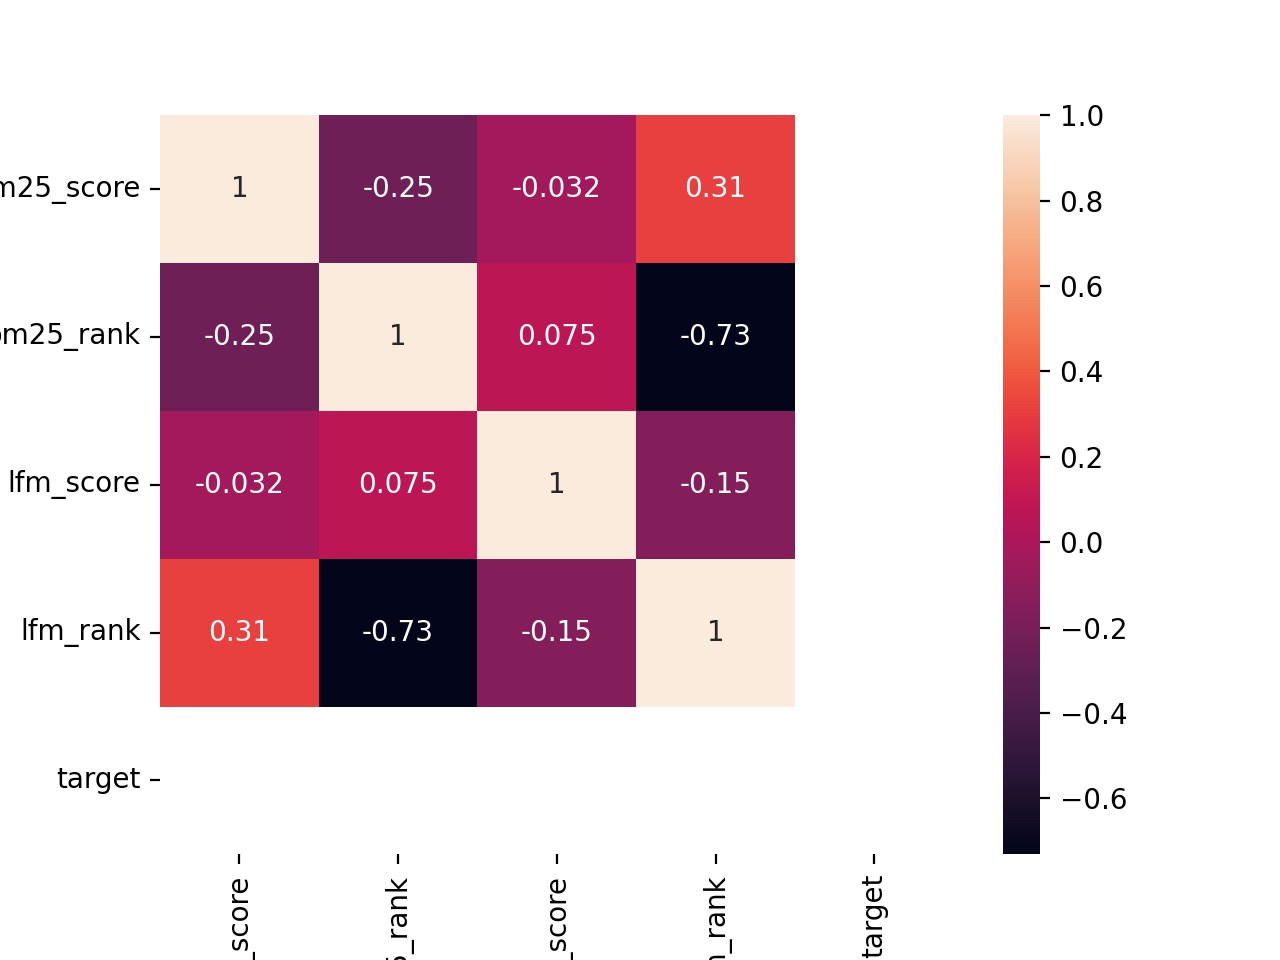

In [ ]:
sns.heatmap(dataset.corr(), annot=True);

In [ ]:
Y = dataset.pop("target")
X = dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

X_train = x_train[['bm25_score', 'bm25_rank', 'lfm_score','lfm_rank']]
X_test = x_test[['bm25_score', 'bm25_rank', 'lfm_score','lfm_rank']]
train_data, test_data = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_test, y_test)

In [ ]:
params = {'objective': 'binary',
          'metric': 'binary_logloss',
          "num_threads": 20,
          'verbose': 1,
          'learning_rate': 4e-4}

model = lightgbm.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=40,
                       verbose_eval=10)

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 51684
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 51684, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 40 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

In [ ]:
lgb_test = x_test.copy()
lgb_test[['client_id', 'product_id']].drop_duplicates(inplace=True)
lgb_test.set_index(['client_id', 'product_id'], inplace=True)
lgb_test["lgb_score"] = model.predict(lgb_test, num_iteration=model.best_iteration)
lgb_test = lgb_test.set_index('lgb_score', append=True).sort_values("lgb_score", ascending=False)
lgb_test.drop_duplicates(inplace=True)

dataset_predicted = dict()
lgb_test.reset_index(inplace=True)
for user, group in tqdm(lgb_test.groupby("client_id")):
    dataset_predicted[user] = list(group.product_id)[:20]

0it [00:00, ?it/s]


In [ ]:
lgb_test

,client_id,product_id,lgb_score,bm25_score,bm25_rank,lfm_score,lfm_rank
0,NaN,NaN,1.000000e-15,0.323490,263.0,456.930939,2.0
1,NaN,NaN,1.000000e-15,0.323490,263.0,2.044757,96.0
2,NaN,NaN,1.000000e-15,7.269334,109.0,0.008554,276.0
3,NaN,NaN,1.000000e-15,0.323490,263.0,-0.492175,195.0
4,NaN,NaN,1.000000e-15,41.375854,20.0,0.008554,276.0
...,...,...,...,...,...,...,...
22140,NaN,NaN,1.000000e-15,54.993820,211.0,0.008554,276.0
22141,NaN,NaN,1.000000e-15,0.323490,263.0,0.272089,120.0
22142,NaN,NaN,1.000000e-15,7.015032,88.0,0.008554,276.0
22143,NaN,NaN,1.000000e-15,0.323490,263.0,-3.765345,175.0
